In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [45]:
orph_segue = Table.read('/Users/adrian/Downloads/orph_spec.fits')
orph_rrl = Table.read('/Users/adrian/Downloads/gdr2_orphan_sergey.fits')

segue_c = coord.SkyCoord(ra=orph_segue['ra']*u.deg,
                         dec=orph_segue['dec']*u.deg)
segue_c = segue_c.transform_to(gc.KoposovOrphan)

rrl_c = coord.SkyCoord(ra=orph_rrl['ra']*u.deg,
                       dec=orph_rrl['dec']*u.deg,
                       distance=orph_rrl['heldist']*u.kpc,
                       pm_ra_cosdec=orph_rrl['pmra']*u.mas/u.yr,
                       pm_dec=orph_rrl['pmdec']*u.mas/u.yr,
                       radial_velocity=0*u.km/u.s)
rrl_c = rrl_c.transform_to(gc.KoposovOrphan)
rrl_c = gc.reflex_correct(rrl_c)

phi1 = rrl_c.phi1.wrap_at(180*u.deg).degree
phi1_mask = (phi1 > -20) & (phi1 < 80)
# orph_rrl = orph_rrl[phi1_mask]
# rrl_c = rrl_c[phi1_mask]

Text(0.5,1,'SEGUE')

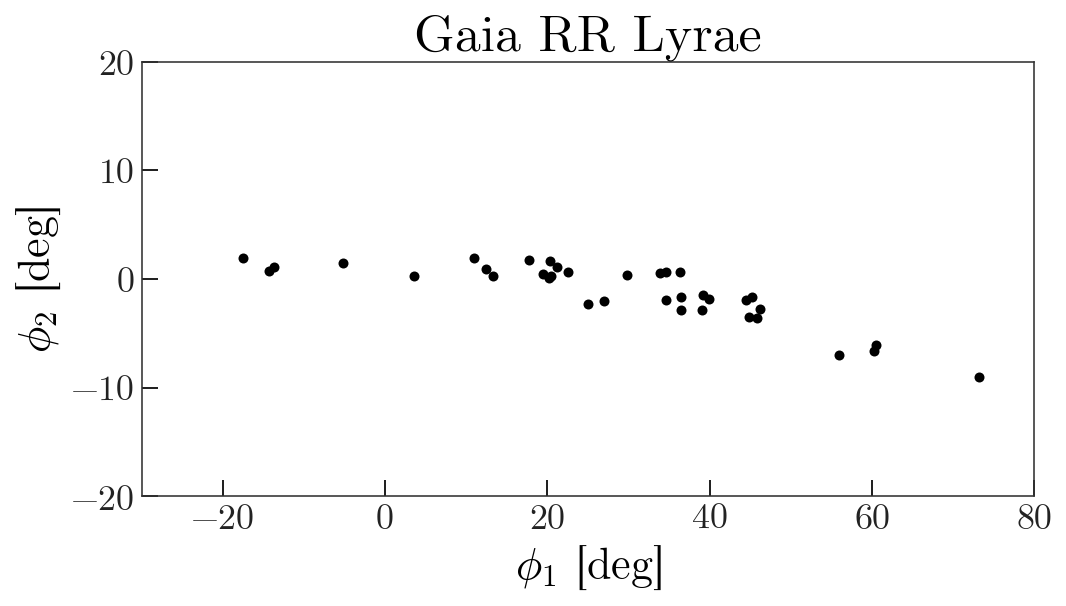

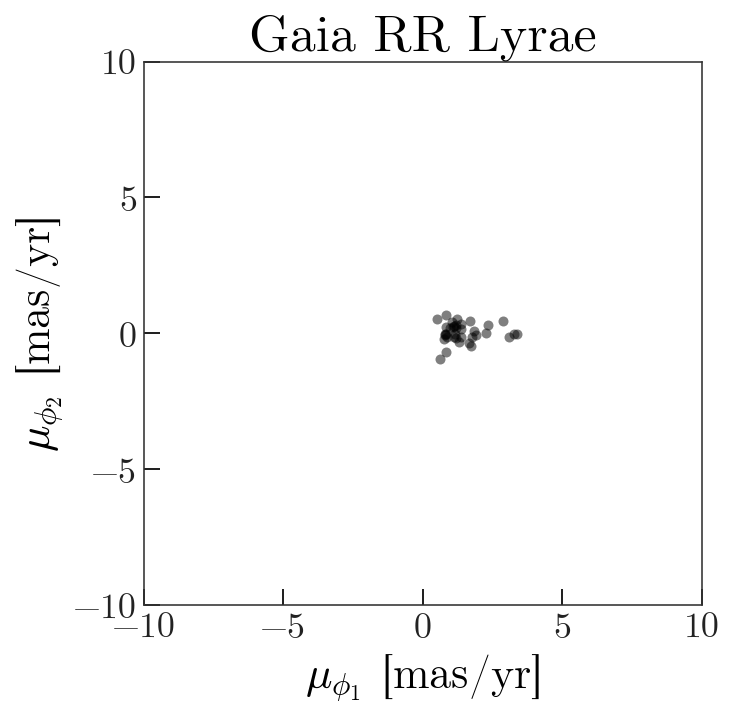

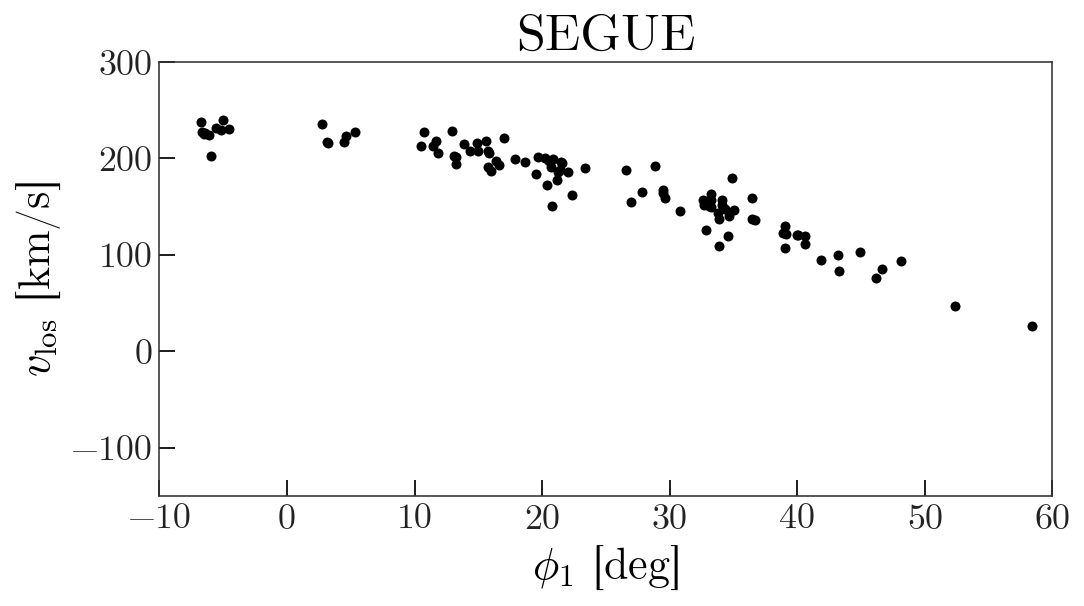

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(rrl_c.phi1.wrap_at(180*u.deg),
        rrl_c.phi2, marker='o', 
        ls='none', ms=5, color='k')
ax.set_xlim(-30, 80)
ax.set_ylim(-20, 20)
ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')
ax.set_title('Gaia RR Lyrae')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(rrl_c.pm_phi1_cosphi2.value,
        rrl_c.pm_phi2.value, marker='o', 
        ls='none', ms=5, color='k', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel(r'$\mu_{\phi_1}$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]')
ax.set_title('Gaia RR Lyrae')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(segue_c.phi1.wrap_at(180*u.deg),
        orph_segue['vel'], marker='o', 
        ls='none', ms=5, color='k')
ax.set_xlim(-10, 60)
ax.set_ylim(-150, 300)
ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$v_{\rm los}$ [km/s]')
ax.set_title('SEGUE')

## APOGEE data

In [20]:
apogee_gaia = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')

In [21]:
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]

# select distant stuff
apogee_gaia = apogee_gaia[apogee_gaia['parallax'] < 1.]

g = GaiaData(apogee_gaia)
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


231808

In [22]:
orp_mask = np.array(['ORP' in f for f in apogee_gaia['FIELD']])
orp_mask.sum()

817

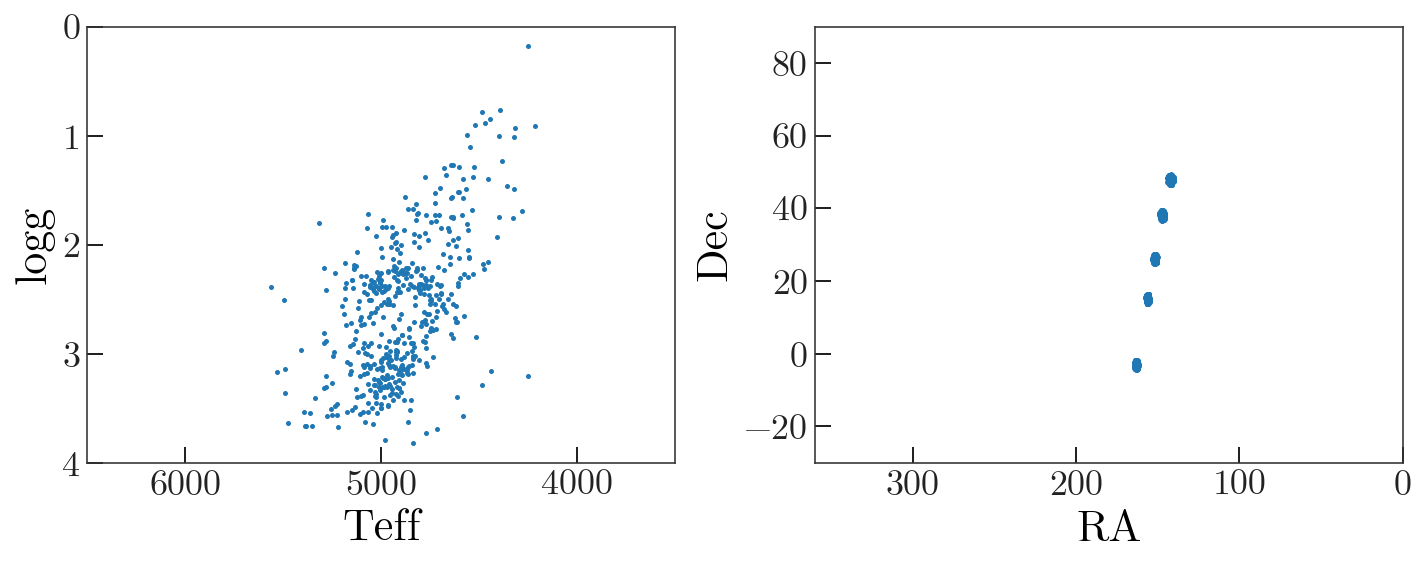

In [36]:
mask = orp_mask

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.plot(apogee_gaia['TEFF'][mask], apogee_gaia['LOGG'][mask], 
        marker='.', linestyle='none')
ax.set_xlabel('Teff')

ax.set_xlim(6500, 3500)
ax.set_ylim(4, 0)
ax.set_ylabel('logg')

ax = axes[1]
ax.plot(apogee_gaia['RA'][mask], apogee_gaia['DEC'][mask], 
        marker='.', linestyle='none')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_xlim(360, 0)
ax.set_ylim(-30, 90)

fig.tight_layout()

In [25]:
c = g.get_skycoord(distance=8*u.kpc, 
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
# c = gc.reflex_correct(c.transform_to(gc.GD1))
c = c.transform_to(gc.KoposovOrphan)

phi1 = c.phi1.wrap_at(180*u.deg)
phi2 = c.phi2

pm1 = c.pm_phi1_cosphi2.to(u.mas/u.yr)
pm2 = c.pm_phi2.to(u.mas/u.yr)

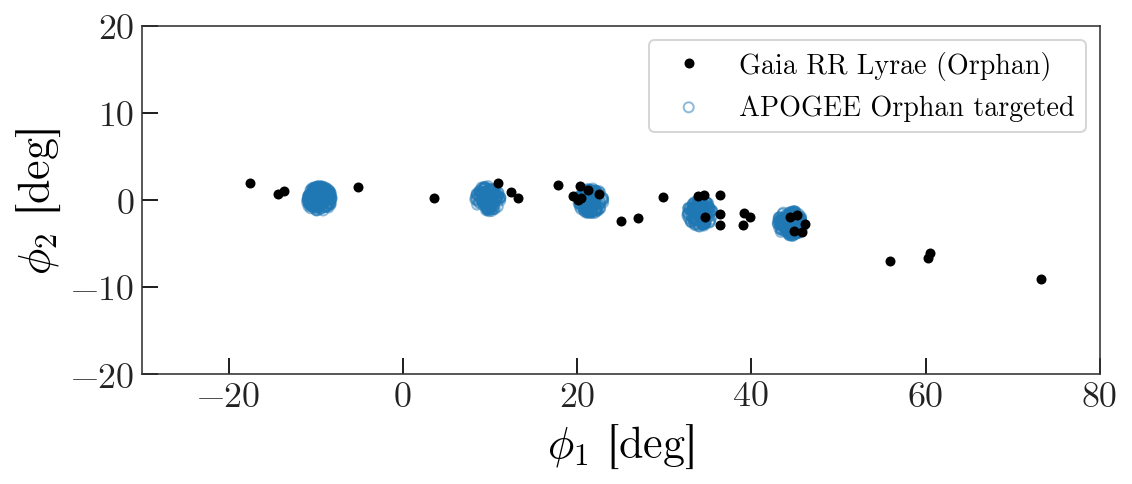

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.scatter(phi1[orp_mask], phi2[orp_mask], 
           marker='o', edgecolor='tab:blue', 
           linewidth=1, facecolor='none', 
           alpha=0.5, zorder=-10,
           label='APOGEE Orphan targeted')

ax.plot(rrl_c.phi1.wrap_at(180*u.deg),
        rrl_c.phi2, marker='o', 
        ls='none', ms=5, color='k',
        label='Gaia RR Lyrae (Orphan)')

ax.set_xlim(-30, 80)
ax.set_ylim(-20, 20)

ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

ax.legend(loc='best', fontsize=14)

fig.tight_layout()
fig.savefig('../plots/orphan/full-phi1phi2.png', dpi=250)

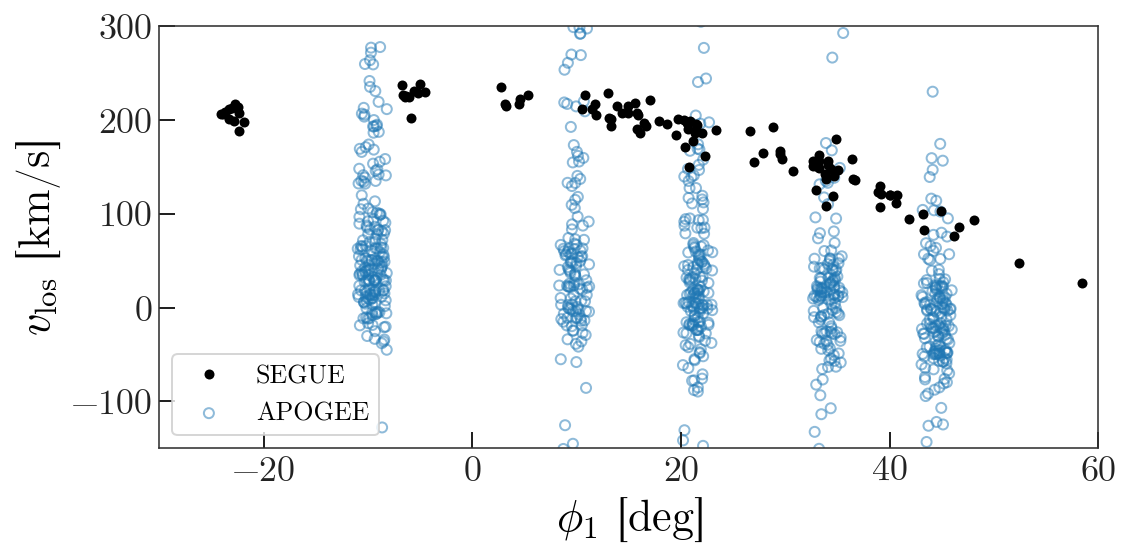

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.scatter(phi1[orp_mask],
           g.VHELIO_AVG[orp_mask],
           marker='o', edgecolor='tab:blue', 
           linewidth=1, facecolor='none', 
           alpha=0.5, zorder=-10, label='APOGEE')

ax.plot(segue_c.phi1.wrap_at(180*u.deg),
        orph_segue['vel'], marker='o', 
        ls='none', ms=5, color='k', label='SEGUE')

ax.set_xlim(-30, 60)
ax.set_ylim(-150, 300)

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$v_{\rm los}$ [km/s]')

ax.legend(loc='lower left', fontsize=13)
fig.tight_layout()
fig.savefig('../plots/orphan/rv.png', dpi=250)

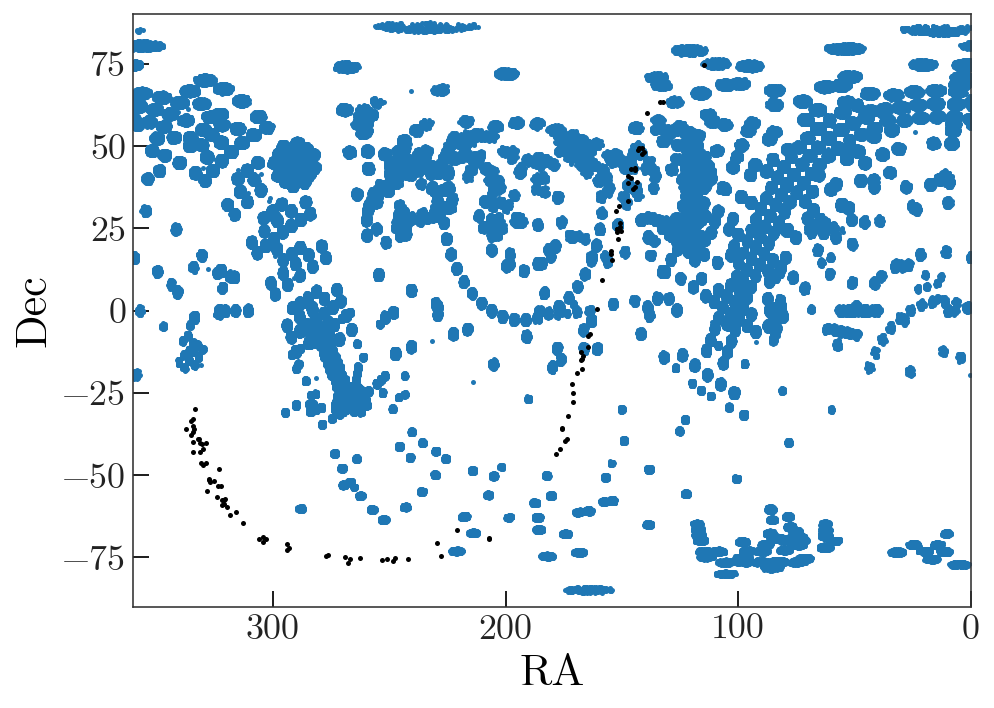

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# ax.plot(apogee_gaia['RA'][orp_mask], 
#         apogee_gaia['DEC'][orp_mask], 
#         marker='.', linestyle='none')
ax.plot(apogee_gaia['RA'], 
        apogee_gaia['DEC'], 
        marker='.', linestyle='none')

ax.plot(orph_rrl['ra'], orph_rrl['dec'],
        ls='none', ms=5, color='k')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.set_xlim(360, 0)
ax.set_ylim(-90, 90)

fig.tight_layout()